3 Observations:

1. CBS tends to tweet out news that are more positive according to the sentiment scale
2. CNN tends to tweet out news that are more negative according to the sentiment scale
3. New York Times has an average overall compound score close to 0 while in the scatter plot, 
we see a pretty even distribution of tweets in both positive and negative range. This can indicate their tweets' sentiment are quite balanced. 

In [1]:
# Dependencies
import tweepy
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
style.use('ggplot')

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
from config import (consumer_key, 
                    consumer_secret, 
                    access_token, 
                    access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [2]:
# Target Search Term
target_terms = ("@BBC", "@CBS", "@cnnbrk",
                "@FoxNews", "@nytimes")
           
# Variable for max_id
oldest_tweet = None
    
# Variables for holding sentiments
sentiment = []

# Loop through all target users
for target in target_terms:
    
    # Counter
    counter = 1
    
    # Variable for holding the oldest tweet
    oldest_tweet = None

    # Variables for holding sentiments
    compound_list = []
    positive_list = []
    negative_list = []
    neutral_list = []
    
    # Loop through 5 page of tweets (total 100 tweets)
    for x in range(5):

        # Get all tweets from home feed
        public_tweets = api.user_timeline(target, max_id = oldest_tweet)

        # Loop through all tweets 
        for tweet in public_tweets:

            # Print Tweets
#             print("Tweet %s: %s" % (counter, tweet["text"]))

            # Run Vader Analysis on each tweet
            results = analyzer.polarity_scores(tweet["text"])
            compound = results["compound"]
            pos = results["pos"]
            neu = results["neu"]
            neg = results["neg"]
            tweets_ago = counter

            # Get Tweet ID, subtract 1, and assign to oldest_tweet
            oldest_tweet = tweet['id'] - 1

            # Add sentiments for each tweet into a list
            sentiment.append({"Date": tweet["created_at"],
                               "Source": target,
                               "Tweet": tweet["text"],
                               "Compound": compound,
                               "Positive": pos,
                               "Negative": neu,
                               "Neutral": neg,
                               "Tweets Ago": counter})

            # Add to counter 
            counter += 1                

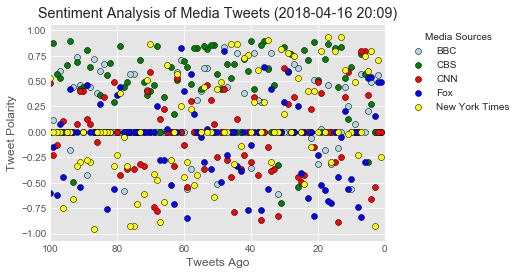

In [3]:
#Put the sentiment list into a dataframe
sentiment_pd = pd.DataFrame.from_dict(sentiment)

#export this data to csv
sentiment_pd.to_csv("sentiment_data.csv")

#Create a new dataframe for each news source
bbc_pd = pd.DataFrame.from_dict(sentiment_pd.loc[sentiment_pd["Source"] == "@BBC"])
cbs_pd = pd.DataFrame.from_dict(sentiment_pd.loc[sentiment_pd["Source"] == "@CBS"])
cnn_pd = pd.DataFrame.from_dict(sentiment_pd.loc[sentiment_pd["Source"] == "@cnnbrk"])
fox_pd = pd.DataFrame.from_dict(sentiment_pd.loc[sentiment_pd["Source"] == "@FoxNews"])
nytimes_pd = pd.DataFrame.from_dict(sentiment_pd.loc[sentiment_pd["Source"] == "@nytimes"])

#Set up the scatter plots for each news source
bbc = plt.scatter(bbc_pd["Tweets Ago"], bbc_pd["Compound"], marker="o", facecolors="lightblue", edgecolors="black", alpha=1, label="BBC")
cbs = plt.scatter(cbs_pd["Tweets Ago"], cbs_pd["Compound"], marker="o", facecolors="green", edgecolors="black", alpha=1, label="CBS")
cnn = plt.scatter(cnn_pd["Tweets Ago"], cnn_pd["Compound"], marker="o", facecolors="red", edgecolors="black", alpha=1, label="CNN")
fox = plt.scatter(fox_pd["Tweets Ago"], fox_pd["Compound"], marker="o", facecolors="blue", edgecolors="black", alpha=1, label="Fox")
nytimes = plt.scatter(nytimes_pd["Tweets Ago"], nytimes_pd["Compound"], marker="o", facecolors="yellow", edgecolors="black", alpha=1, label="New York Times")

#Plot the scatterplot with the legends
lgd = plt.legend(handles=[bbc, cbs, cnn, fox, nytimes], loc='upper right', bbox_to_anchor=(1.4,1), fancybox=True, title="Media Sources")
lgd

#Get the current timestamp
now = datetime.now()
now = now.strftime("%Y-%m-%d %H:%M")

#set the title, x limit, x-label, and y-label
plt.title(f"Sentiment Analysis of Media Tweets ({now})")
plt.xlim([100,0]) 
plt.ylabel("Tweet Polarity")
plt.xlabel("Tweets Ago")

#Save the scatter plot as a png with extra parameters to have legend included in the image
plt.savefig('scatter_plot.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

#Show the scatter plot
plt.show()

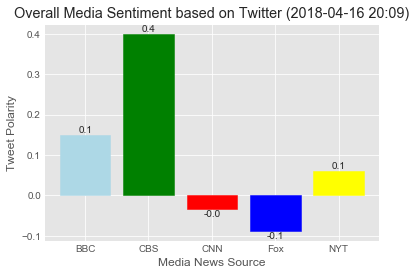

In [4]:
#Get an array of the mean compound for each news source
sentiment_mean = [bbc_pd["Compound"].mean(), 
             cbs_pd["Compound"].mean(),
             cnn_pd["Compound"].mean(),
             fox_pd["Compound"].mean(),
             nytimes_pd["Compound"].mean(),
            ]

#Set the range of the x_axis
x_axis = np.arange(len(sentiment_mean))

#Plot the bar chart and set unique colors for each news source
barlist = plt.bar(x_axis, sentiment_mean, align="edge")
barlist[0].set_color('lightblue')
barlist[1].set_color('green')
barlist[2].set_color('red')
barlist[3].set_color('blue')
barlist[4].set_color('yellow')

barlist.patches

#set the tick locations and name the x_axis
tick_locations = [value+0.4 for value in x_axis]
plt.xticks(tick_locations, ["BBC", "CBS", "CNN", "Fox", "NYT"])

#Give the bar chart a title, x-label and y-label
plt.ylabel("Tweet Polarity")
plt.xlabel("Media News Source")
plt.title(f"Overall Media Sentiment based on Twitter ({now})")

for rect in barlist:
    # Get X and Y placement of label from rect.
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    # Number of points between bar and label. Change to your liking.
    space = 0.5
    # Vertical alignment for positive values
    va = 'bottom'

    # If value of bar is negative: Place label below bar
    if y_value < 0:
        # Invert space to place label below
        space *= -1
        # Vertically align label at top
        va = 'top'

    # Use Y value as label and format number with one decimal place
    label = "{:.1f}".format(y_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(0, space),          # Vertically shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        ha='center',                # Horizontally center label
        va=va)                      # Vertically align label differently for
                                    # positive and negative values.
#use seaborn library to set the style to white background
sns.set_style(style='white')

#save the figure
plt.savefig('bar_chart.png')

#Show the scatter plot
plt.show()